In [1]:
%reload_ext rpy2.ipython

c:\Users\Vuki\AppData\Local\Programs\Python\Python39\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [ ]:
%%R

install.packages("gtrendsR")
library(gtrendsR)

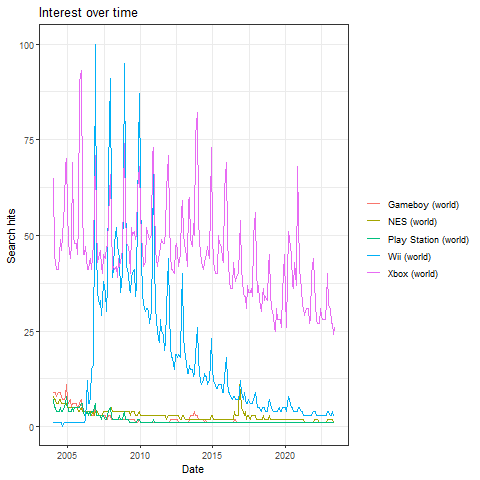

In [3]:
%%R

# Input the names of platforms
platformKeywords <- c("Wii", "NES", "Gameboy", "Play Station", "Xbox")


# Get Google Trends data
platform_trends_data <- gtrends(platformKeywords, time = "all")


plot(platform_trends_data)


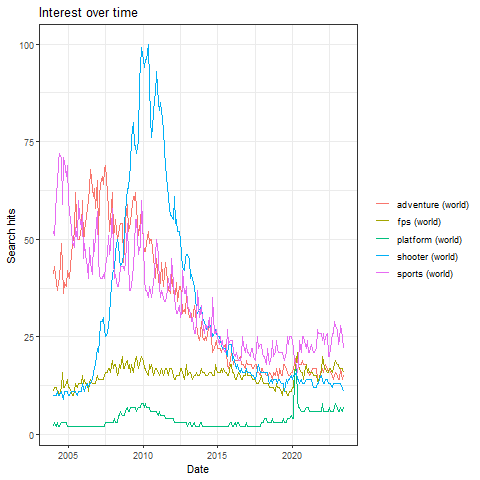

In [5]:
%%R

# Input the names of platforms
genreKeywords <- c("shooter", "sports", "platform", "adventure", "fps" )


# Get Google Trends data, specifying only game searches 8, only web searches
genre_trends_data <- gtrends(genreKeywords, time = "all", category = "8", gprop = "web")


plot(genre_trends_data)

In [6]:
%%R

library(readr)

# Load data
sales_data <- read_csv("Data/vgsales.csv")

# Filter for years 2004 and onwards
sales_data <- sales_data[sales_data$Year >= 2004, ]


Rows: 16598 Columns: 11
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (5): Name, Platform, Year, Genre, Publisher
dbl (6): Rank, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
%%R

library(dplyr)

# Get average global sales for top 5 genres over time
average_sales <- sales_data %>%
  group_by(Genre, Year) %>%
  summarize(Avg_Sales = mean(Global_Sales, na.rm = TRUE)) %>%
  ungroup()

# Get top 5 genres by total sales
top_genres <- average_sales %>%
  group_by(Genre) %>%
  summarize(Total_Sales = sum(Avg_Sales, na.rm = TRUE)) %>%
  top_n(5, Total_Sales) %>%
  pull(Genre)

# Filter average sales for top 5 genres
average_sales <- average_sales[average_sales$Genre %in% top_genres, ]


R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




`summarise()` has grouped output by 'Genre'. You can override using the
`.groups` argument.


In [8]:
%%R

# Normalize average sales to range 0-100 to fit the Google trends scale
normalize <- function(x) {
  return ((x - min(average_sales$Avg_Sales)) / (max(average_sales$Avg_Sales)) * 100)
}

average_sales$Normalized_Sales <- normalize(average_sales$Avg_Sales)


In [9]:
%%R

library(gtrendsR)

# Initialize a list to hold trends data
trends_data_list <- list()

# Loop through top genres
for (genre in top_genres) {
  
  # Get Google Trends data
  trends_data <- gtrends(genre, time = "all", category = "8", gprop = "web")
  
  # Store interest over time in the list
  trends_data_list[[genre]] <- trends_data$interest_over_time
  
}

# Combine all data frames in the list
trends_data <- do.call(rbind, trends_data_list)

# Convert date to year
trends_data$Year <- as.numeric(format(trends_data$date, "%Y"))

# Average trends data over years
average_trends <- trends_data %>%
  group_by(keyword, Year) %>%
  summarize(Avg_Hits = mean(hits, na.rm = TRUE)) %>%
  ungroup()

# Rename columns to match sales data
names(average_trends) <- c("Genre", "Year", "Normalized_Hits")


`summarise()` has grouped output by 'keyword'. You can override using the
`.groups` argument.


In [10]:
%%R

# Merge sales and trends data
comparison_data <- merge(average_sales, average_trends, by = c("Genre", "Year"))

# View the comparison data
print(comparison_data)


          Genre Year Avg_Sales Normalized_Sales Normalized_Hits
1      Platform 2004 0.7172727        35.838659       14.500000
2      Platform 2005 0.2838554        13.561730       12.666667
3      Platform 2006 0.9222222        46.372722       11.916667
4      Platform 2007 0.8473810        42.526005       14.416667
5      Platform 2008 0.5758065        28.567527       27.916667
6      Platform 2009 1.4168966        71.798160       39.583333
7      Platform 2010 1.0290323        51.862580       38.500000
8      Platform 2011 0.7597297        38.020878       26.333333
9      Platform 2012 1.5458333        78.425296       17.666667
10     Platform 2013 0.6789189        33.867337       14.416667
11     Platform 2014 0.8890000        44.665155       13.333333
12     Platform 2015 0.4321429        21.183458       12.500000
13     Platform 2016 0.2070000         9.611489       13.333333
14       Racing 2004 0.6740845        33.618856       77.583333
15       Racing 2005 0.7327273        36

R[write to console]: Use suppressPackageStartupMessages() to eliminate package startup
messages



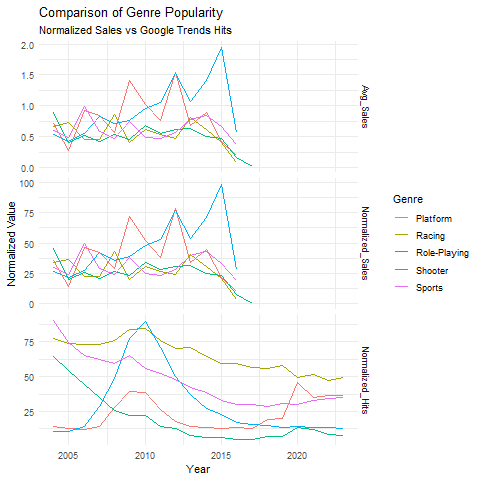

In [11]:
%%R

# Load ggplot2
library(ggplot2)

# Merge sales and trends data
comparison_data <- merge(average_sales, average_trends, by = c("Genre", "Year"), all = TRUE)


# Melt the data for graphing
comparison_data_melt <- reshape2::melt(comparison_data, id.vars = c("Genre", "Year"))

# Convert Year to numeric
comparison_data_melt$Year <- as.numeric(comparison_data_melt$Year)

# Plot the graph
ggplot(comparison_data_melt, aes(x = Year, y = value, color = Genre)) +
  geom_line() +
  facet_grid(variable ~ ., scales = "free_y") +
  labs(x = "Year", y = "Normalized Value", color = "Genre",
       title = "Comparison of Genre Popularity",
       subtitle = "Normalized Sales vs Google Trends Hits") +
  theme_minimal()

In [12]:
%%R

average_sales <- sales_data %>%
  group_by(Platform, Year) %>%
  summarize(Avg_Sales = mean(Global_Sales, na.rm = TRUE)) %>%
  ungroup()

normalize <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)) * 100)
}

average_sales$Normalized_Sales <- normalize(average_sales$Avg_Sales)



`summarise()` has grouped output by 'Platform'. You can override using the
`.groups` argument.


In [13]:
%%R

library(gtrendsR)

# Get a list of the top 5 platforms
top_platforms <- tail(names(sort(table(sales_data$Platform))), 5)

# Initialize a list to hold trends data
trends_data_list <- list()

# Loop through top platforms
for (platform in top_platforms) {
  
  # Get Google Trends data
  trends_data <- gtrends(platform, time = "all", category = "899", gprop = "web")
  
  # Convert 'hits' to numeric
  trends_data$interest_over_time$hits <- as.numeric(trends_data$interest_over_time$hits)
  
  # Store interest over time in the list
  trends_data_list[[platform]] <- trends_data$interest_over_time
}

# Combine all data frames in the list
trends_data <- do.call(rbind, trends_data_list)

# Convert date to year
trends_data$Year <- as.numeric(format(trends_data$date, "%Y"))

# Average trends data over years
average_trends <- trends_data %>%
  group_by(keyword, Year) %>%
  summarize(Normalized_Hits = mean(hits, na.rm = TRUE)) %>%
  ungroup()

# Rename columns to match sales data
names(average_trends) <- c("Platform", "Year", "Normalized_Hits")

`summarise()` has grouped output by 'keyword'. You can override using the
`.groups` argument.


In [14]:
%%R

# Convert 'Year' to numeric in both data frames
average_sales$Year <- as.numeric(average_sales$Year)
average_trends$Year <- as.numeric(average_trends$Year)

# Merge the two data frames
comparison_data <- merge(average_sales, average_trends, by = c("Platform", "Year"), all = TRUE)

comparison_data <- inner_join(average_sales, average_trends, by = c("Platform" = "Platform", "Year" = "Year")) %>%
  filter(Platform %in% top_platforms)



In [20]:
%%R

print(n=53, comparison_data)

# A tibble: 53 x 5
   Platform  Year Avg_Sales Normalized_Sales Normalized_Hits
   <chr>    <dbl>     <dbl>            <dbl>           <dbl>
 1 DS        2004    0.759            24.0             12.3 
 2 DS        2005    1.11             35.3             22.4 
 3 DS        2006    0.600            18.9             41.4 
 4 DS        2007    0.396            12.4             49.6 
 5 DS        2008    0.301             9.30            54.2 
 6 DS        2009    0.301             9.32            46.1 
 7 DS        2010    0.270             8.32            29.7 
 8 DS        2011    0.182             5.50            19.2 
 9 DS        2012    0.466            14.6             12.5 
10 DS        2013    0.218             6.65             9.75
11 DS        2014    0.02              0.320            7.42
12 DS        2020    0.29              8.96             5.25
13 PS2       2004    0.818            25.9             65.4 
14 PS2       2005    0.618            19.5             54.5 
15 PS

In [18]:
%%R

print(top_platforms)

[1] "X360" "Wii"  "PS3"  "PS2"  "DS"  


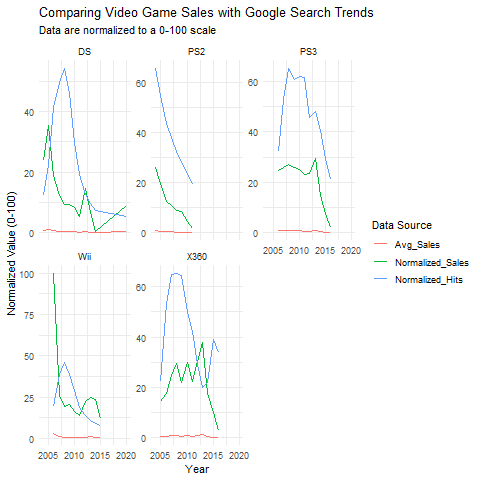

In [16]:
%%R

library(ggplot2)

# Convert data to long format
comparison_data_melt <- reshape2::melt(comparison_data, id.vars = c("Platform", "Year"))

# Plot data
ggplot(comparison_data_melt, aes(x = Year, y = value, color = variable, group = interaction(Platform, variable))) +
  geom_line() +
  facet_wrap(~ Platform, scales = "free_y") +
  theme_minimal() +
  labs(y = "Normalized Value (0-100)", color = "Data Source",
       title = "Comparing Video Game Sales with Google Search Trends",
       subtitle = "Data are normalized to a 0-100 scale")
